In [1]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import GPUtil

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import torch.nn as nn
import torchvision.models as models
from pytorch_pretrained_bert import BertModel
from transformers import DistilBertModel
import torch.nn.functional as F

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
# Reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

### Structure
- plot images
- text preprocessing
- data loader
- image augmentation

### Text Preprocessing

Bert requires: <br>
- tokenization
- special characters
- padding
- mask

techniques to try (for other models): <br>
- Lower casing
- Punctuation removal
- Stopwords removal
- Frequent words removal
- Rare words removal
- Spelling correction
- Tokenization
- Stemming
- Lemmatization
- word embedding/ bag of words

In [3]:
df = pd.read_pickle('../data/labeled_data.p')

# analyze imbalance
print(df["class"].value_counts())

# drop class 1 for the first
df = df.drop(df[df['class'] == 1].index)
df = df.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# convert class 2 -> 1 to be in accordance with standards
def convert_standard(x):
    return 0 if x == 0 else 1
df['class'] = df['class'].apply(convert_standard)

print(df["class"].value_counts())

print(df.head(10))


1    19190
2     4163
0     1430
Name: class, dtype: int64
1    4163
0    1430
Name: class, dtype: int64
     class                                              tweet
0        1  !!! RT @mayasolovely: As a woman you shouldn't...
40       1    " momma said no pussy cats inside my doghouse "
63       1  "@Addicted2Guys: -SimplyAddictedToGuys http://...
66       1  "@AllAboutManFeet: http://t.co/3gzUpfuMev" woo...
67       1  "@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...
70       1  "@ArizonasFinest6: Why the eggplant emoji doe?...
75       1  "@BabyAnimalPics: baby monkey bathtime http://...
85       0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...
90       0  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
111      0  "@DevilGrimz: @VigxRArts you're fucking gay, b...


In [4]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

df['tweet'] = df['tweet'].apply(preprocess)
df = df[df["tweet"]!='']

print(df.head())


    class                                              tweet
0       1  ! rt as a woman you shouldnt complain about cl...
40      1        momma said no pussy cats inside my doghouse
63      1                               simplyaddictedtoguys
67      1  lemmie eat a oreo amp do these dishes one oreo...
70      1  why the eggplant emoji doe?y he say she looked...


In [5]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)

print(dataset_df)

# dictionary
data = df.to_dict(orient='records') # have been shuffled in previous step

print(df)

# train valid split
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(data, test_size=0.2)
valid_data, _ = train_test_split(valid_data, test_size=0.9)




         id            img  label  \
0     42953  img/42953.png      0   
1     23058  img/23058.png      0   
2     13894  img/13894.png      0   
3     37408  img/37408.png      0   
4     82403  img/82403.png      0   
...     ...            ...    ...   
8495  10423  img/10423.png      1   
8496  98203  img/98203.png      1   
8497  36947  img/36947.png      1   
8498  16492  img/16492.png      1   
8499  15937  img/15937.png      1   

                                                   text  
0      its their character not their color that matters  
1     don't be afraid to love again everyone is not ...  
2                              putting bows on your pet  
3     i love everything and everybody! except for sq...  
4     everybody loves chocolate chip cookies, even h...  
...                                                 ...  
8495                  nobody wants to hang auschwitz me  
8496  when god grants you a child after 20 years of ...  
8497  gays on social media: equal

In [6]:
# split into text (input) and labels (output)
train_texts, train_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), train_data)))
valid_texts, valid_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

(4467, 4467, 111, 111)

In [7]:
# class imbalance
print(sum(train_labels)/ len(train_labels))
print(sum(valid_labels)/ len(valid_labels))

0.7443474367584508
0.6486486486486487


In [8]:
# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [9]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:14] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:14] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(4467, 111)

In [10]:
# put everything back into a dictionary
data_train = {'tokens': train_tokens, 'labels': train_labels}

data_valid = {'tokens': valid_tokens, 'labels': valid_labels}

## Dataloader

In [11]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data

    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'tokens': train_tokens, 'labels': train_labels}
        
        # label ------------------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token -------------------------------------------
        token = self.data['tokens'][idx]

        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=16, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        # mask for padding -> required by bert
        mask = [float(i > 0) for i in token_id]
        mask = np.array([mask])
        mask = mask.astype('float').reshape(-1)
        
        #
        sample = {'token_id': token_id, 'mask': mask, 'label': label}
            
        return sample

## Model 

In [12]:
# https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2
class MyEnsemble(nn.Module):
    def __init__(self):
        super(MyEnsemble, self).__init__()
        # pretrained models
        self.modelNLP = BertModel.from_pretrained('bert-base-cased')
        
        # classifier layer
        self.layernorm1 = torch.nn.LayerNorm(768)
        self.classifier1 = nn.Linear(768, 1000)
        self.layernorm2 = torch.nn.LayerNorm(1000)
        self.classifier2 = nn.Linear(1000, 2)
        
    def forward(self, tokens, masks):
        # Bert is such that the first token contains all info for classification
        _, x2 = self.modelNLP(tokens, attention_mask=masks, output_all_encoded_layers=False)
        x = self.layernorm1(x2)
        x = F.relu(self.classifier1(x))
        x = self.layernorm2(x)
        y = self.classifier2(x) # torch.nn.softmax(.)
        
        
        
        return y

In [13]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = MyEnsemble().to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

GPUtil.showUtilization()

print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

436.864512M
| ID | GPU | MEM |
------------------
|  0 | 26% | 23% |
109084810
109084810


In [14]:
from torch.optim import Adam
# TODO: not sure if this does what I think it should do
# optimizer
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr) # TODO: SGD for just the final classifier

In [15]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:        
        # TODO: should work since target = {0, 1}, thus sets weights to zero if not needed
        loss = weights * (target * torch.log(output)) + \
               weights * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [16]:
from datetime import date
# summary writer
log_dir = './summaries/summary'+ date.today().strftime('%H-%d-%m-%Y')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir)

## Training

In [25]:
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import roc_auc_score

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

EPOCHS=5
BATCH_SIZE_TRAIN=16 # 4 if grad for all paramters
BATCH_SIZE_VALID=4

# training
train_dataset = HatefulMemesDataset(data_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, num_workers=1, shuffle=True)

# validation
valid_dataset = HatefulMemesDataset(data_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_VALID, shuffle=False)

# loss fcn
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': [], 'val_rocauc': []}

time_tot = []

for epoch_num in range(EPOCHS):
    #
    train_loss = 0.
    train_correct = 0.
    
    valid_loss = 0.
    valid_correct = 0.
    
    # training ---------------------------------------------------
    model.train()
        
    for step_num, batch in enumerate(train_loader):
        
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}                
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)
        # imgs, token_ids, masks, labels = tuple(t.to(device) for t in batch)
        # print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        
        logits = model(token_ids, masks)
        
        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
   
        # loss
        batch_loss = loss_fn(logits, labels.squeeze())
        train_loss += batch_loss.item()
        train_correct += sum((torch.argmax(logits, dim=1)==torch.reshape(labels, [-1]))).item()
        
        '''
        batch_loss = weighted_binary_cross_entropy(logits, labels.float())
        train_loss += batch_loss.item()
        train_correct += sum((torch.round(logits)==labels)).item()
        '''
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        # gradient clipping and backward pass
        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        # logging
        # clear_output(wait=True) -> from IPython.display import clear_output
        if step_num%50==0 and step_num> 0:
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} acc: {3} ".format(step_num,
                                                              len(train_data) / BATCH_SIZE_TRAIN,
                                                              round(train_loss / (step_num + 1), 3),
                                                              round(train_correct/ ((step_num+1)* BATCH_SIZE_TRAIN), 3)))
    
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* BATCH_SIZE_TRAIN))
    stats['train_acc'].append(train_correct / ((step_num+1)* BATCH_SIZE_TRAIN))
    
    writer.add_scalar('Loss/train', train_loss / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    writer.add_scalar('Accuracy/train', train_correct / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    
    # validation ---------------------------------------
    # TODO to calculate metrics
    ypred = []
    ytrue = []
    weight = []

    for step_num, batch in enumerate(valid_loader):
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)

        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (eye+ (labels==eye).int())* 0.63
        
        # loss
        logits = model(token_ids, masks)
        
        batch_loss = loss_fn(logits, labels.squeeze())
        valid_loss += batch_loss.item()
        valid_correct += sum((torch.argmax(logits, dim=1)==torch.reshape(labels, [-1]))).item()

        '''
        batch_loss = weighted_binary_cross_entropy(logits, labels.float())
        valid_loss += batch_loss.item()
        
        valid_correct += sum((torch.round(logits)==labels)).item()
        '''

    # valid stats
    stats['valid_loss'].append(valid_loss / ((step_num+1)* BATCH_SIZE_VALID))
    stats['valid_acc'].append(valid_correct / ((step_num+1)* BATCH_SIZE_VALID))
    
    writer.add_scalar('Loss/valid', valid_loss / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)
    writer.add_scalar('Accuracy/valid', valid_correct / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)

    # optimizer lr decay
    lr*= 0.9
    optimizer = Adam(model.parameters(), lr=lr)
    
writer.close()

Epoch:  1
50/279.1875 loss: 2.742 acc: 0.946 
Epoch:  1
100/279.1875 loss: 2.619 acc: 0.947 
Epoch:  1
150/279.1875 loss: 2.661 acc: 0.947 
Epoch:  1
200/279.1875 loss: 2.788 acc: 0.943 
Epoch:  1
250/279.1875 loss: 2.815 acc: 0.942 
Epoch:  2
50/279.1875 loss: 1.496 acc: 0.972 
Epoch:  2
100/279.1875 loss: 1.695 acc: 0.968 
Epoch:  2
150/279.1875 loss: 1.803 acc: 0.964 
Epoch:  2
200/279.1875 loss: 1.704 acc: 0.967 
Epoch:  2
250/279.1875 loss: 1.679 acc: 0.966 
Epoch:  3
50/279.1875 loss: 0.748 acc: 0.984 
Epoch:  3
100/279.1875 loss: 0.904 acc: 0.982 
Epoch:  3
150/279.1875 loss: 0.851 acc: 0.981 
Epoch:  3
200/279.1875 loss: 0.861 acc: 0.982 
Epoch:  3
250/279.1875 loss: 0.828 acc: 0.983 
Epoch:  4
50/279.1875 loss: 0.423 acc: 0.991 
Epoch:  4
100/279.1875 loss: 0.449 acc: 0.99 
Epoch:  4
150/279.1875 loss: 0.557 acc: 0.989 
Epoch:  4
200/279.1875 loss: 0.581 acc: 0.989 
Epoch:  4
250/279.1875 loss: 0.537 acc: 0.99 
Epoch:  5
50/279.1875 loss: 0.299 acc: 0.996 
Epoch:  5
100/279.18

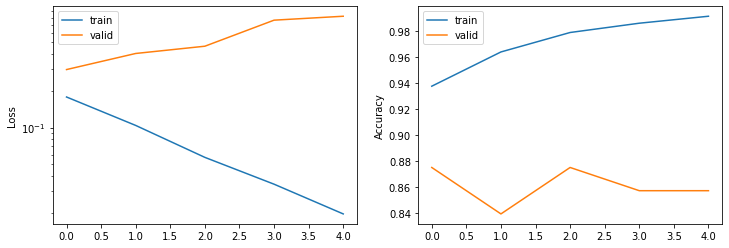

In [26]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')

plt.savefig('../classifier_11_10.png')
plt.show()